# SNF for lattice $\textrm{SU}(3)$
Andrea Bulgarelli, Elia Cellini and Alessandro Nada

The following notebook provides an introduction to the code used in our paper **[Scaling of Stochastic Normalizing Flows in $\textrm{SU}(3)$ lattice gauge theory](https://arxiv.org/abs/2412.00200)**, if this code is useful for your research, please cite us:


```
@article{Bulgarelli:2024brv,
    author = "Bulgarelli, Andrea and Cellini, Elia and Nada, Alessandro",
    title = "{Scaling of Stochastic Normalizing Flows in $\mathrm{SU}(3)$ lattice gauge theory}",
    eprint = "2412.00200",
    archivePrefix = "arXiv",
    primaryClass = "hep-lat",
    month = "11",
    year = "2024"
}
```


<ins>**For an introduction on Stochastic Normalizing Flows for lattice field theory, see also this notebook: [SNF_for_LFT](https://github.com/TurinLatticeFieldTheoryGroup/SNF_for_LFT)**</ins>

The algorithm presented in this notebook is a **Stochastic Normalizing Flows (SNF)** made by interliving deterministic gauge equivariant layers and stochastic Monte Carlo updates. In the following, we will introduce the stochastic parts, and then the deterministic ones. In the last section, we will train and test a simple SNF.

## Utility Stuff for SU(3) calculations

The main two libraries used in this implementation are NumPy and PyTorch. The low-level parts of the code are not discussed in this notebook. Please proceed by running and skipping to the next section.


In [1]:
import numpy as np
import torch
import torch.utils.checkpoint as checkpoint
import matplotlib.pyplot as plt
import time

In [2]:
if torch.cuda.is_available():
    torch_device = 'cuda'
    float_dtype = np.float64
    torch.set_default_dtype(torch.float64)
    torch.set_default_device('cuda')
else:
    torch_device = 'cpu'
    float_dtype = np.float64
    torch.set_default_dtype(torch.float64)

print(f"TORCH DEVICE: {torch_device}")

TORCH DEVICE: cuda


In [3]:
#### Utility
def torch_mod(x):
    return torch.remainder(x, 2*np.pi)
def torch_wrap(x):
    return torch_mod(x+np.pi) - np.pi
def grab(var):
    return var.detach().cpu().numpy()


def SUN_identity(init_shape):
    id = torch.ones(init_shape, dtype=torch.cdouble)
    return torch.diag_embed(id)

def hot_SU2_start_nonuniform(init_shape_SU2):
    x0 = torch.rand(init_shape_SU2, dtype=torch.cdouble)
    nrm = torch.norm(x0, dim = -1)
    x0 = x0 / nrm.unsqueeze(-1)

    x1 = torch.conj((x0 * torch.tensor([1,-1]).view([1]*(len(init_shape_SU2)-1)+[2])).roll(1,-1))

    return torch.cat((x0.unsqueeze(-2),x1.unsqueeze(-2)),-2)

def SUN_determinant(cfgs):
    return torch.linalg.det(cfgs)

def SUN_trace(cfgs):
    return torch.einsum('...ii', cfgs)

def check_determinant_SUN(cfgs, tol):
    dtm = SUN_determinant(cfgs)
    return (dtm - 1.0).abs() > tol

def SUN_dagger(cfgs):
    return torch.conj(torch.transpose(cfgs,-2,-1))

def SUN_mul(U,V):
    return torch.einsum('...ij,...jk->...ik',U,V)

def plaquette_SUN(cfgs, D, N):
    retr = torch.zeros(cfgs[:,0].shape[:-2], dtype = torch.double)
    dims = range(1,D+1)
    for nu in range(1,D):
        for mu in range(0,nu):
            plaq = SUN_mul(SUN_dagger(cfgs[:,nu]),cfgs[:,mu])
            plaq = SUN_mul(plaq,torch.roll(cfgs,1,dims=(-D + mu - 2))[:,nu])
            plaq = SUN_mul(plaq,SUN_dagger(torch.roll(cfgs,1,dims=(-D + nu - 2)))[:,mu])
            retr += SUN_trace(plaq).real
    return torch.mean(retr, tuple(dims))/(D*(D-1)/2)/N


def create_mask(D, T, L):
    mask_shape = (2*D,D,T)
    for i in range(1,D):
        mask_shape += (L,)

    mask = torch.zeros(mask_shape, dtype = int)
    for mu in range(D):
        for t in range(T):
            for x in range(L):
                if(D>2):
                    for y in range(L):
                        if(D>3):
                            for z in range(L):
                                parity = t + x + y + z
                                mask[parity%2+mu*2,mu,t,x,y,z] = 1
                        else:
                            parity = t + x + y
                            mask[parity%2+mu*2,mu,t,x,y] = 1
                else:
                    parity = t + x
                    mask[parity%2+mu*2,mu,t,x] = 1

    return mask.unsqueeze(1).unsqueeze(-1).unsqueeze(-1)

def pstaple(cfgs, mu, nu, D):
    pstaple = SUN_mul(torch.roll(cfgs,1,dims=(-D + mu - 2))[:,nu], SUN_dagger(torch.roll(cfgs,1,dims=(-D + nu - 2)))[:,mu])
    return SUN_mul(pstaple, SUN_dagger(cfgs[:,nu]))

def nstaple(cfgs, mu, nu, D):
    nstaple = SUN_mul(SUN_dagger(torch.roll(cfgs,(1,-1),dims=(-D + mu - 2,-D + nu - 2))[:,nu]), SUN_dagger(torch.roll(cfgs,-1,dims=(-D + nu - 2)))[:,mu])
    return SUN_mul(nstaple, torch.roll(cfgs,-1,dims=(-D + nu - 2))[:,nu])

### heatbath

def sum_of_staples(cfgs, mu, D, device):
    staple = torch.zeros(cfgs[:,0].shape, dtype=torch.cdouble).to(device)
    for nu in range(D):
        if nu != mu:
            pstaple = SUN_mul(torch.roll(cfgs,1,dims=(-D + mu - 2))[:,nu],
                              SUN_dagger(torch.roll(cfgs,1,dims=(-D + nu - 2)))[:,mu])
            pstaple = SUN_mul(pstaple, SUN_dagger(cfgs[:,nu]))
            staple += pstaple
            nstaple = SUN_mul(SUN_dagger(torch.roll(cfgs,(1,-1),dims=(-D + mu - 2,-D + nu - 2))[:,nu]),
                              SUN_dagger(torch.roll(cfgs,-1,dims=(-D + nu - 2)))[:,mu])
            nstaple = SUN_mul(nstaple, torch.roll(cfgs,-1,dims=(-D + nu - 2))[:,nu])
            staple += nstaple

    return staple

def SU2_element(mat, i, j):
    return torch.index_select(torch.index_select(mat,-2,i),-1,j).squeeze(-1).squeeze(-1)

def SU2toSU3(Ak, phb, device):
    A = torch.zeros(Ak.shape[:-2] + (2,1)).to(device)
    B = torch.cat((torch.index_select(Ak,-1,torch.arange(phb)),A,torch.index_select(Ak,-1,torch.arange(phb,2))),-1)
    A = torch.zeros(Ak.shape[:-2] + (1,2)).to(device)
    C = torch.ones(Ak.shape[:-2] + (1,1)).to(device)
    AA = torch.cat((torch.index_select(A,-1,torch.arange(phb)),C,torch.index_select(A,-1,torch.arange(phb,2))),-1)
    return torch.cat((torch.index_select(B,-2,torch.arange(phb)),AA,torch.index_select(B,-2,torch.arange(phb,2))),-2)


def heatbath(prefactor, mu, D, rand, device):
    #WARNING: if rand[:,0] and one of the two other rand are simultaneously 0 a NaN occurs in the gradient of mod. Probably very unlikely
    lam2 = (- 1.0 / (2.0 * prefactor) * (rand[:,0,mu,:] + rand[:,1,mu,:] * rand[:,2,mu,:]))
    acc = (1.0 - lam2 >= rand[:,3,mu,:]**2)

    x0 = (1.0 - 2.0 * lam2) * acc
    #x0=x0.detach() # This detach prevents (unlikely) NaN in the gradient of the square root mod
    stheta = torch.sqrt(1.0 - rand[:,4,mu,:]**2)
    mod = torch.sqrt(1.0 - x0**2)

    A = torch.complex(x0, mod*rand[:,4,mu,:]).unsqueeze(-1)
    B = (stheta*mod*torch.complex(torch.cos(rand[:,5,mu,:]), torch.sin(rand[:,5,mu,:]))).unsqueeze(-1)
    Xa = torch.ones(prefactor.shape + (1,)).to(device) * A
    Xb = torch.ones(prefactor.shape + (1,)).to(device) * B
    X = torch.cat((Xa,Xb),-1)

    v1 = torch.conj((X * torch.tensor([1,-1]).view([1]*(len(X.shape)-1)+[2])).roll(1,-1))
    Xmat = torch.cat((X.unsqueeze(-2),v1.unsqueeze(-2)),-2)
    acc = acc.unsqueeze(-1).unsqueeze(-1)

    return Xmat, acc

def SU2_link_update_hb(beta, cfgs, mu, D, rand, device):
    staples = sum_of_staples(cfgs, mu, D, device)
    k = torch.sqrt(SUN_determinant(staples).abs())
    staples = staples / k.unsqueeze(-1).unsqueeze(-1)

    Xmat, acc = heatbath(beta*k, mu, D, rand[:,0:6], device)
    new_cfgs = SUN_mul(Xmat, SUN_dagger(staples)) * acc + cfgs * ~acc
    return new_cfgs.unsqueeze(1)

def SU2_link_update_over(cfgs, mu, D, device):
    staples = sum_of_staples(cfgs, mu, D, device)
    k = torch.sqrt(SUN_determinant(staples).abs())
    staples = staples / k.unsqueeze(-1).unsqueeze(-1)

    staples = SUN_dagger(staples)
    new_cfgs = SUN_mul(SUN_mul(staples, SUN_dagger(cfgs)), staples)
    return new_cfgs.unsqueeze(1)

def SU3_compute_RK(new_cfgs, staples, sel, phb):
    sel2 = sel[sel != phb]
    Rk = SUN_mul(new_cfgs, staples)# SUN_dagger(staples))

    #generate SU(2) subgroup matrix from Rk
    a = 0.5*(SU2_element(Rk,sel2[0],sel2[0]) + torch.conj(SU2_element(Rk,sel2[1],sel2[1]))).unsqueeze(-1)
    b = 0.5*(SU2_element(Rk,sel2[0],sel2[1]) - torch.conj(SU2_element(Rk,sel2[1],sel2[0]))).unsqueeze(-1)
    v0 = torch.cat((a,b),-1)
    v1 = torch.conj((v0 * torch.tensor([1,-1]).view([1]*(len(v0.shape)-1)+[2])).roll(1,-1))
    Rk = torch.cat((v0.unsqueeze(-2),v1.unsqueeze(-2)),-2)
    k = torch.sqrt(SUN_determinant(Rk).abs())
    Rk = Rk / k.unsqueeze(-1).unsqueeze(-1)
    return Rk, k

def SU3_link_update_hb(beta, cfgs, mu, D, rand, device):
    #staples = sum_of_staples(cfgs, mu, D, device)
    staples = checkpoint.checkpoint(sum_of_staples, cfgs, mu, D, device, use_reentrant=False)
    phb_steps = 3
    new_cfgs = cfgs[:,mu]
    sel = torch.tensor([0,1,2]).to(device)
    for phb in range(phb_steps):
        Rk, k = SU3_compute_RK(new_cfgs, staples, sel, phb)
        Xmat, acc = heatbath(2.0*beta*k/3.0, mu, D, rand[:,6*phb:6*(phb+1),:], device)
        Ak = SUN_mul(Xmat, SUN_dagger(Rk))
        Ak = SU2toSU3(Ak, phb, device)
        new_cfgs = SUN_mul(Ak, new_cfgs) * acc + new_cfgs * ~acc
    return new_cfgs.unsqueeze(1)

def SU3_link_update_over(cfgs, mu, D, device):
    #staples = sum_of_staples(cfgs, mu, D, device)
    staples = checkpoint.checkpoint(sum_of_staples, cfgs, mu, D, device, use_reentrant=False)
    phb_steps = 3
    new_cfgs = cfgs[:,mu]
    sel = torch.tensor([0, 1, 2])
    for phb in range(phb_steps):
        Rk, k = SU3_compute_RK(new_cfgs, staples, sel, phb)
        i0 = torch.tensor([0])
        i1 = torch.tensor([1])
        a = (SU2_element(Rk,i1,i1)*SU2_element(Rk,i1,i1)+SU2_element(Rk,i0,i1)*SU2_element(Rk,i1,i0)).unsqueeze(-1)
        b = (-SU2_element(Rk,i1,i1)*SU2_element(Rk,i0,i1)-SU2_element(Rk,i0,i1)*SU2_element(Rk,i0,i0)).unsqueeze(-1)
        v0 = torch.cat((a,b),-1)
        v1 = torch.conj((v0 * torch.tensor([1,-1]).view([1]*(len(v0.shape)-1)+[2])).roll(1,-1))
        Ak = torch.cat((v0.unsqueeze(-2),v1.unsqueeze(-2)),-2)
        #bring Ak back to SU(3)
        Ak = SU2toSU3(Ak, phb, device)
        #new link is Ak*old_link
        new_cfgs = SUN_mul(Ak, new_cfgs)
    return new_cfgs.unsqueeze(1)

#haar measure sampling

def haar_heatbath(rand, cfgs_shape, device):
    x0 = rand[:,0,:]
    acc = (1.0 - x0**2 >= rand[:,3,:]**2)

    x0 = x0 * acc
    stheta = torch.sqrt(1.0 - rand[:,4,:]**2)
    mod = torch.sqrt(1.0 - x0**2)

    A = torch.complex(x0, mod*rand[:,4,:]).unsqueeze(-1)
    B = (stheta*mod*torch.complex(torch.cos(rand[:,5,:]), torch.sin(rand[:,5,:]))).unsqueeze(-1)
    Xa = torch.ones(cfgs_shape[:-2] + (1,)).to(device) * A
    Xb = torch.ones(cfgs_shape[:-2] + (1,)).to(device) * B
    v0 = torch.cat((Xa,Xb),-1)

    v1 = torch.conj((v0 * torch.tensor([1,-1]).view([1]*(len(v0.shape)-1)+[2])).roll(1,-1))
    Xmat = torch.cat((v0.unsqueeze(-2),v1.unsqueeze(-2)),-2)
    acc = acc.unsqueeze(-1).unsqueeze(-1)

    return Xmat, acc

def SU2_link_haar_hb(cfgs, rand, device):
    Xmat, acc = haar_heatbath(rand[:,0:6], cfgs.shape, device)
    new_cfgs = Xmat * acc + cfgs * ~acc
    return new_cfgs

def SU3_link_haar_hb(cfgs, rand, device):
    phb_steps = 3
    new_cfgs = cfgs
    for phb in range(phb_steps):
        Xmat, acc = haar_heatbath(rand[:,6*phb:6*(phb+1),:], cfgs.shape, device)
        Ak = SU2toSU3(Xmat, phb, device)
        new_cfgs = SUN_mul(Ak, new_cfgs) * acc + new_cfgs * ~acc

    return new_cfgs

def init_hb(N, mask, D, orsteps, rn_shape, init_shape):
    if N==2:
        hb_update=SU2_link_update_hb
        haar_hb_update=SU2_link_haar_hb
        over_update=SU2_link_update_over
    elif N==3:
        hb_update=SU3_link_update_hb
        haar_hb_update=SU3_link_haar_hb
        over_update=SU3_link_update_over

    def update(cfgs, beta, device):
        rand = torch.rand(rn_shape).to(device)
        if beta == 0.0:
            #rand = torch.rand(rn_shape)
            for rr in range(rn_shape[1]//6):
                rand[:,rr*6] = 1.0 - 2.0 * rand[:,rr*6]
                rand[:,rr*6+4] = 1.0 - 2.0 * rand[:,rr*6+4]
                rand[:,rr*6+5] = 2.0 * torch.pi * rand[:,rr*6+5]

            cfgs = haar_hb_update(cfgs, rand, device)
        else:
            for rr in range(rn_shape[1]//6):
                rand[:,rr*6] = torch.log(1.0 - rand[:,rr*6])
                rand[:,rr*6+1] = torch.cos(2.0 * torch.pi *(1.0 - rand[:,rr*6+1]))**2
                rand[:,rr*6+2] = torch.log(1.0 - rand[:,rr*6+2])
                rand[:,rr*6+4] = 1.0 - 2.0 * rand[:,rr*6+4]
                rand[:,rr*6+5] = 2.0 * torch.pi * rand[:,rr*6+5]

            for mu in range(D):
                for eo in range(2):
                    current_mask = mask[eo+mu*2,:]
                    cfgs_new = hb_update(beta, cfgs, mu, D, rand, device)
                    cfgs = current_mask * cfgs_new + (1-current_mask) * cfgs

            for o in range(orsteps):
                for mu in range(D):
                    for eo in range(2):
                        current_mask = mask[eo+mu*2,:]
                        cfgs_new = over_update(cfgs, mu, D, device)
                        cfgs = current_mask * cfgs_new + (1-current_mask) * cfgs
        return cfgs

    return update



#functions for smearing:
def xi0(w, w2):
    return torch.where(torch.abs(w) > 0.005, torch.sin(w)/w, 1. - 1./6.*w2*(1. - 1./20.*w2*(1. - 1./42.*w2)))

def xi1(w, w2):
    return torch.where(torch.abs(w) > 0.005, torch.cos(w)/w2 - torch.sin(w)/w**3,
                       -1./3. + w2*(1./30. + w2*(-1./840 + 1./45360.*w2)))

def xi2(w, w2, xizero, xione):
    return torch.where(torch.abs(w) > 0.005, 1./w2*(xizero + 3. * xione), -1./15. + w2*(1./210. - w2/7560.))

#stuff for Jacobian
def otimes(A,B):
    return torch.einsum('...ij,...kl->...ijkl',A,B)

def oplus(A,B):
    return torch.einsum('...kj,...il->...ijkl',A,B)

def starprod(A,B):
    return torch.einsum('...inml,...njkm->...ijkl',A,B)

def starprodmat(A,B):
    return torch.einsum('...ijkn,...nl->...ijkl',A,B)

def matstarprod(A,B):
    return torch.einsum('...in,...njkl->...ijkl',A,B)

def generate_coefficients(Q, Q2, id, oidid, oidQ, device):
    c0 = SUN_determinant(Q)
    c1 = .5 * SUN_trace(Q2)
    c0max = 2.0 * (c1 / 3.0)**1.5

    sgnc0 = torch.real(torch.sgn(c0))
    c0 = torch.abs(c0)

    theta = torch.arccos(c0/c0max)
    u = torch.sqrt(c1/3.0) * torch.cos(theta/3.0)
    w = torch.sqrt(c1) * torch.sin(theta/3.0)
    u2 = u**2
    w2 = w**2
    cw = torch.cos(w)
    eu = torch.cos(u) + 1.j*torch.sin(u)
    eu2 = eu**2
    eum = eu**(-1)

    xizero = xi0(w, w2)
    xione = xi1(w, w2)

    h0 = (u2 - w2)*eu2 + eum*(8.*u2*cw + 2.j*u*(3.*u2 + w2)*xizero)
    h1 = 2.*u*eu2 - eum*(2.*u*cw - 1.j*(3.*u2 - w2)*xizero)
    h2 = eu2 - eum*(cw + 3.j*u*xizero)

    r10 = 2.*(u + 1.j*(u2 - w2))*eu2 + 2.*eum*(4.*u*(2.-1.j*u)*cw + 1.j*(9.*u2 + w2 - 1.j*u*(3.*u2 + w2)) * xizero)
    r11 = 2.*(1. + 2.j*u)*eu2 + eum*(-2.*(1.-1.j*u)*cw + 1.j*(6.*u + 1.j*(w2 - 3.*u2))*xizero)
    r12 = 2.j*eu2 + 1.j*eum*(cw - 3.*(1.-1.j*u)*xizero)
    r20 = -2.*eu2 + 2.j*u*eum*(cw + (1.+4.j*u)*xizero + 3.*u2*xione)
    r21 = -1.j*eum*(cw + (1.+2.j*u)*xizero - 3.*u2*xione)
    r22 = eum * (xizero - 3.j*u*xione)

    den = 9.*u2 - w2
    den2 = 2. * den**2
    v3u2mw2 = 3.*u2 - w2
    v15u2pw2 = 15.*u2 + w2

    f0 = h0 / den
    f1 = h1 / den
    f2 = h2 / den

    b10 = (2.*u*r10 + v3u2mw2 * r20 - 2.*v15u2pw2*f0) / den2
    b11 = (2.*u*r11 + v3u2mw2 * r21 - 2.*v15u2pw2*f1) / den2
    b12 = (2.*u*r12 + v3u2mw2 * r22 - 2.*v15u2pw2*f2) / den2
    b20 = (r10 - 3.*u*r20 - 24.*u*f0) / den2
    b21 = (r11 - 3.*u*r21 - 24.*u*f1) / den2
    b22 = (r12 - 3.*u*r22 - 24.*u*f2) / den2

    f0 = torch.where(sgnc0 > 0, f0, torch.conj(f0))
    f1 = torch.where(sgnc0 > 0, f1, -torch.conj(f1))
    f2 = torch.where(sgnc0 > 0, f2, torch.conj(f2))

    b10 = torch.where(sgnc0 > 0, b10, torch.conj(b10))
    b11 = torch.where(sgnc0 > 0, b11, -torch.conj(b11))
    b12 = torch.where(sgnc0 > 0, b12, torch.conj(b12))
    b20 = torch.where(sgnc0 > 0, b20, -torch.conj(b20))
    b21 = torch.where(sgnc0 > 0, b21, torch.conj(b21))
    b22 = torch.where(sgnc0 > 0, b22, -torch.conj(b22))

    B1 = b10.unsqueeze(-1).unsqueeze(-1) * id + b11.unsqueeze(-1).unsqueeze(-1) * Q +\
         + b12.unsqueeze(-1).unsqueeze(-1) * Q2
    B2 = b20.unsqueeze(-1).unsqueeze(-1) * id + b21.unsqueeze(-1).unsqueeze(-1) * Q +\
         + b22.unsqueeze(-1).unsqueeze(-1) * Q2

    return f0.unsqueeze(-1).unsqueeze(-1), f1.unsqueeze(-1).unsqueeze(-1), f2.unsqueeze(-1).unsqueeze(-1), B1, B2

def generate_omega(C, U):
    return SUN_mul(C, SUN_dagger(U))

def generate_Q(omega, N):   #check i in definition
    return 0.5 * 1.j * (SUN_dagger(omega) - omega) - 0.5 * 1.j/N * SUN_trace(SUN_dagger(omega) - omega).unsqueeze(-1).unsqueeze(-1)

def generate_expQ(Q, Q2, id, f0, f1, f2):
    return f0 * id + f1 * Q + f2 * Q2

def generate_dQ_domega(N, oidid, id):
    A = oidid
    B = oplus(id, id)
    return -1.j*(.5 * A - .5/N * B)

def generate_dexpQ_dQ(Q, Q2, B1, B2, f1, f2, id, oidid, oidQ):
    M = oplus(Q, B1)
    M += oplus(Q2, B2)
    M += f1.unsqueeze(-1).unsqueeze(-1)*oidid
    M += f2.unsqueeze(-1).unsqueeze(-1)*oidQ
    return M

def generate_domega_dU(C, id):
    return -otimes(id, SUN_dagger(C))

def generate_domega_dC(U, oidid):
    return starprodmat(oidid, SUN_dagger(U))

def generate_dQ_dU(dQdomega, id, C):
    B = generate_domega_dU(C, id)
    return starprod(dQdomega, B)

def generate_dQ_dC(dQdomega, oidid, U):
    B = generate_domega_dC(U, oidid)
    return starprod(dQdomega, B)

def generate_dexpQ_dU(dexpQdQ, dQ_dU):
    return starprod(dexpQdQ, dQ_dU)

def generate_Jacobian_U(dexpQdU, U, expQ, oidid):
    return starprodmat(dexpQdU, U) + matstarprod(expQ, oidid)

def generate_Jacobian_C(dexpQdQ, dQdC, U):
    A = starprod(dexpQdQ, dQdC)
    return starprodmat(A, U)

def Jacobian_reshape(jac, jac_shape):
    return torch.einsum('...ijkl->...iljk',jac).reshape(jac_shape)

def det_Jac(J):
    return torch.linalg.det(J)

def stout_staples(cfgs, mu, D, rho, device):
    staple = torch.zeros(cfgs[:,0].shape, dtype=torch.cdouble).to(device)
    if len(rho) == 1:
        for nu in range(D):
            if nu != mu:
                staple += rho * (SUN_dagger(pstaple(cfgs, mu, nu, D)) + SUN_dagger(nstaple(cfgs, mu, nu, D)))
    else:
        for nu in range(D):
            if nu != mu:
                staple += rho[nu] * (SUN_dagger(pstaple(cfgs, mu, nu, D)) + SUN_dagger(nstaple(cfgs, mu, nu, D)))
    return staple

def stout_smearing(cfgs, mu, D, rho, jac_shape, device):
    C = checkpoint.checkpoint(stout_staples, cfgs, mu, D, rho, device, use_reentrant=False, preserve_rng_state=False)

    U = cfgs[:,mu]
    id = SUN_identity(U.shape[:-1])
    N = U.shape[-1]
    omega = generate_omega(C, U)
    Q = generate_Q(omega, N)
    Q2 = SUN_mul(Q, Q)

    oidid = otimes(id, id)
    oidQ = otimes(id, Q) + otimes(Q, id)

    f0, f1, f2, B1, B2 = generate_coefficients(Q, Q2, id, oidid, oidQ, device)
    expQ = generate_expQ(Q, Q2, id, f0, f1, f2)
    dexpQdQ = generate_dexpQ_dQ(Q, Q2, B1, B2, f1, f2, id, oidid, oidQ)

    dQdomega = generate_dQ_domega(N, oidid, id)
    dQdU = generate_dQ_dU(dQdomega, id, C)
    dexpQdU = generate_dexpQ_dU(dexpQdQ, dQdU)
    Jacobian_U = generate_Jacobian_U(dexpQdU, U, expQ, oidid)
    detjac = det_Jac(Jacobian_reshape(Jacobian_U, jac_shape)).abs()

    return SUN_mul(expQ, U).unsqueeze(1), detjac.unsqueeze(1)


## Target Action

In this notebook, we target $\textrm{SU}(3)$ gauge theory. Although some parts of the code are written for a general number of colors $N$, this implementation works only for $N=3$.

In [4]:
class S_SUN:
    def __init__(self, D,N):
      self.D=D
      self.N=N
    def __call__(self,cfgs, beta):
      retr = torch.zeros(cfgs[:,0].shape[:-2], dtype = torch.double)
      dims = range(1,self.D+1)
      for nu in range(1,self.D):
          for mu in range(0,nu):
              plaq = SUN_mul(SUN_dagger(cfgs[:,nu]),cfgs[:,mu])
              plaq = SUN_mul(plaq,torch.roll(cfgs,1,dims=(-self.D + mu - 2))[:,nu])
              plaq = SUN_mul(plaq,SUN_dagger(torch.roll(cfgs,1,dims=(-self.D + nu - 2)))[:,mu])
              retr += SUN_trace(plaq).real

      return beta*torch.sum(6.0 - retr/self.N, tuple(dims))

## Prior

In our work, we used a thermalized MCMC as a prior for our SNFs, implemented in the following class.

In [5]:
class PriorSUN:
    def __init__(self, init_shape, action, beta, update, therm_steps, mcmc_steps, device):
        '''
        This class implements a standard MCMC used as a prior for our SNFs.
        Given a general MCMC update, the class thermalizes a batch of replicas
        at fixed action and then runs a standard MCMC over these samples.
        '''
        self.init_shape=init_shape
        self.update=update
        self.beta=beta
        self.therm_steps=therm_steps #thermalization steps
        self.mcmc_steps=mcmc_steps #sweep steps
        self.action=action
        self.device=device

    def __call__(self, cfgs=None):
        if cfgs != None:
            with torch.no_grad():
                for i in range(self.mcmc_steps):
                    cfgs = self.update(cfgs, self.beta, self.device)
        else:
            with torch.no_grad():
                cfgs = self.therm()
        return cfgs, self.action(cfgs, self.beta)

    def therm(self):
        cfgs = SUN_identity(self.init_shape).to(self.device)
        for i in range(self.therm_steps):
            cfgs = self.update(cfgs, self.beta, self.device)
        return cfgs


## Non-Equilibrium MCMC

The main core of the Non-Equilibrium MCMC used in our work is the heatbath update (see the textbook [Quantum fields on a lattice](https://inspirehep.net/literature/378182)). In this implementation, the heatbath work only for $N=2,3$

Given an MCMC update, the stochastic layer is very simple. Defining the input sample as $U_i$ and the stochastic layer $sl$,
the output $U_o$ is obtained by applying the stochastic update to the input: $U_o=sl(U_i)$. The pseudoheat $Q$ is then computed as the difference between the action of the input and the target: $Q=S(U_o)-S(U_i)$

In [6]:
class NEMCMC_update(torch.nn.Module):
    def __init__(self,action, beta,update,device):
        '''
        This class implement a NE-MCMC steps wrapped in a pytorch module.
        The action and the coupling beta are given by the chosen protocol while
        the update can be a general MCMC transformation that satisfy detailed balance
        '''
        super().__init__()
        self.action=action #action fixed in the MCMC update
        self.update = update #choosen update
        self.beta = beta #coupling of the action
        self.device = device
    def forward(self,cfgs):
        s_old=self.action(cfgs,self.beta)
        cfgs=self.update(cfgs,self.beta,self.device) #get the new samples
        return cfgs, self.action(cfgs,self.beta)-s_old, 0 #output: new configurations and Q

## Gauge Equivariant Layer

In our code, we used a gauge equivariant network inspired by [[Nagai and Tomiya; 2103.11965](https://arxiv.org/abs/2103.11965)] and [[Abbott et al.;2305.02402](https://arxiv.org/abs/2305.02402)], see also [[Morningstar and Peardon; hep-lat/0311018](https://arxiv.org/abs/hep-lat/0311018)].  Our implementation works only for $N=3$.

The following class implements the gauge quivariant layer. Each layer $g_i$ computes the output $U_i=g_i(U_{i-1})$ and the logarithm of the Jacobian of the transformation. To simplify the computation of the Jacobian, we used even-odd masks.

In [7]:
class Smearing(torch.nn.Module):
    def __init__(self, N, mask, D,  jac_shape, scale_fac, rho_shape, device, rho_root=None, smearing_steps=1):
        '''
        Gauge equivariant layer for our SNF. The transformation is a stout
        smearing with learnable parameters, the square root of which
        is the matrix rho_root. This class can be used as a neural network,
        where the number of layers is determined by the parameter smearing_steps.
        '''
        super().__init__()
        self.N = N
        self.mask = mask
        self.D = D
        self.smearing_steps = smearing_steps #numbers of layers for each coupling layer, default 1
        #The class can take as input a trained set of parameters in order to easily transfer them among different models
        if rho_root is None:
            self.rho_root = torch.nn.Parameter(torch.rand(rho_shape).to(device) * scale_fac)
        else:
            self.rho_root = torch.nn.Parameter(rho_root)

        self.jac_shape = jac_shape
        self.device = device

    def forward(self, cfgs):
        ones = (torch.ones(self.mask[0].shape, dtype=torch.double).squeeze(-1).squeeze(-1)).to(self.device)
        bs = cfgs.shape[0]
        dlogJ = torch.zeros(bs, dtype=torch.double).to(self.device)
        dims = tuple(np.arange(1,self.D+2))
        for sm in range(self.smearing_steps): #loops over layers of the coupling layer
            for mu in range(self.D): #loops over dimensions
                for eo in range(2): #loops over even-odd fields
                    current_mask = self.mask[eo+mu*2,:]
                    rho = self.rho_root[sm,eo+mu*2,:]**2
                    cfgs_new, jac = stout_smearing(cfgs, mu, self.D, rho, self.jac_shape, self.device)
                    cfgs = current_mask * cfgs_new + (1-current_mask) * cfgs
                    jac = torch.log(current_mask.squeeze(-1).squeeze(-1) * jac + (1-current_mask.squeeze(-1).squeeze(-1)) * ones)
                    dlogJ += torch.sum(jac, dims)
        return cfgs, 0, dlogJ

## General class for SNF

We can now build a general class for SNFs. The constructor of the class takes as input the target action and coupling, and list of layers.

Given a batch of prior samples $U_0$ and their action $S_0(U_0)$, the class computes the generated samples $U$, the work for the evolutions $[U_0,\cdots, U]$:
$$W(U_0,\cdots, U)= S(U) - S_0(U_0) - Q(U_0,\cdots, U) -\log J(U_0,\cdots, U),$$

where $Q(U_0,\cdots, U)$ is the sum over the pseudoheat of each stochastic layer and $\log J(U_0,\cdots, U)$ is the sum of the logarithms of the Jacobians of the gauge equivariant layers.

The class also computes the free energy difference between target and prior and the ESS.

In [8]:
class Flow:
    def __init__(self, action, coupling, flow):
        super().__init__()
        self.action=action #target action
        self.flow = flow #list of layers
        self.coupling = coupling #target coupling

    def __call__(self,x,s0):
        x, Q, logJ = self.forward(x) #calculation of generated sample x, Q, and logJ
        st = self.action(x,self.coupling)
        w = st - s0 - Q - 2.0*logJ #Calculation of the work W
        deltaF, ess = self.compute_metrics(w)  #calculation of metrics: \Delta F and ESS
        return x, w, deltaF, ess

    def forward(self,x): #Forward of the flow
        Q = torch.zeros(x.shape[0])
        logJ = torch.zeros(x.shape[0])
        for layer in self.flow:
            x, dQ, dlogJ = layer.forward(x)
            Q += dQ
            logJ += dlogJ
        return x, Q, logJ

    def compute_metrics(self,w): #Standard metrics
        wd = w.detach()
        DF = - torch.log(torch.mean(torch.exp(-(wd-wd.mean())))) + wd.mean()
        ess = (torch.mean(torch.exp(-(wd-wd.mean())))**2)/torch.mean(torch.exp(-2.0*(wd-wd.mean())))
        return DF,ess

    def sample_(self,x,s0): #sample function for testing
        with torch.no_grad():
            x, Q, logJ = self.forward(x) #calculation of generated sample x, Q, and logJ
            st = self.action(x,self.coupling)
            w = st - s0 - Q - 2.0*logJ
        return x, w

The following function builds an SNF:

In [9]:
def make_SNF(betas, action, update, N, mask, D, init_shape, jac_shape,torch_device, scale_fac=0.01**4,smearing_steps=1,):
    layers=[]
    for b in betas: #For every beta of the protocol we add:
        #one deterministic layer:
        smr=Smearing( N, mask, D,  jac_shape, scale_fac, (smearing_steps, 2*D, 4), device=torch_device)
        layers.append(smr)
        #one stocastic layer:
        stb=NEMCMC_update(action, b, update, torch_device)
        layers.append(stb)
    flow=Flow(action, betas[-1], torch.nn.ModuleList(layers).to(torch_device))
    return flow

## Play with SU$(3)$ SNFs

We can now play with our SNF, the main parameters needed to initialize the flows are:

- bs: batch size
- D: dimension
- T: temporal extension
- L: spatial extension
- N: colors, this notebook works only for $N=3$
- k(N=2)=6, k(N=3)=18

Shapes:
- configurations shape = (bs, D, T, L,..., L, N, N)
- initialization shape = (bs, D, T, L,..., L, N)
- random numbers shape = (bs, k(N), D, T, L,..., L)

For simplicity, we will test the SNF on $4^4$ lattices.

In [10]:
N=3
D=4
bs=8
T=4
L=4
init_shape=(bs,D,T,L,L,L,N)
jac_shape=(bs,T,L,L,L,N*N,N*N)
rn_shape=(bs,18,D,T,L,L,L)
orsteps=1

Prior, target parameters and the (linear) protocol for the non-equilibrium part:

In [11]:
beta0=6.0 #prior beta
beta_tar=6.2 #target beta
steps_beta=5 #numers of steps of the protocol, i.e. NE-MCMCM updates
betas = np.linspace(beta0 + (beta_tar - beta0)/steps_beta, beta_tar, steps_beta) # Protocol
betas

array([6.04, 6.08, 6.12, 6.16, 6.2 ])

Let's build the SNF:

In [12]:
action = S_SUN(D ,N) #Theory
mask = create_mask(D, T, L).to(torch_device) #even-odd mask
update = init_hb(N, mask, D, orsteps, rn_shape, init_shape) #MCMC update for prior and SNFs

therm_steps= 50 #Thermalization steps for the prior
mcmc_steps = 1 # Sweep steps for the prior
prior = PriorSUN(init_shape, action, beta0, update, therm_steps, mcmc_steps, torch_device)

flow = make_SNF(betas, action, update, N, mask, D, init_shape, jac_shape,torch_device)

### Training

We can now train the SNF using the standard procedure.

In [13]:
n_epochs=100 #number of gradient update
optimizer=torch.optim.Adam(flow.flow.parameters(), lr=0.001) #optimizer
history={'loss':[],'ESS':[]} #saved metrics

In [14]:
if torch_device == 'cuda':
    torch.cuda.empty_cache() #clean the gpu

x0, s0 = prior() #thermalize replicas batch_size of prior samples
for t in range(n_epochs):
    optimizer.zero_grad()
    x0, s0 = prior(cfgs=x0) #apply one standard MCMC step to obtain new prior configurations
    x, w, df, ess = flow(x0, s0) #forward pass of the model
    loss=w.mean() #average Work
    history['loss'].append(grab(loss)) #metrics
    history['ESS'].append(grab(ess)) #metrics
    #print metrics
    print(f'step: {t + 1},'
          f' loss: {grab(loss)},'
          f' w_var: {grab(w.var())},'
          f' ess: {grab(ess)},'
          f' Delta_free_en: {grab(df)}')
    loss.backward() #backward
    optimizer.step() #gradient update


step: 1, loss: 121.91833141136661, w_var: 1.2766864408695855, ess: 0.42733332303792004, Delta_free_en: 121.33116908469485
step: 2, loss: 123.31562144271825, w_var: 2.627479035712949, ess: 0.49158988690765515, Delta_free_en: 122.50960417852444
step: 3, loss: 122.42312240463198, w_var: 1.3859537277422997, ess: 0.5145057925813616, Delta_free_en: 121.88507008236165
step: 4, loss: 122.4597624956364, w_var: 1.4694733103990967, ess: 0.551351786328524, Delta_free_en: 121.9522426210709
step: 5, loss: 122.32839137877238, w_var: 3.1760022215255153, ess: 0.3799742687883824, Delta_free_en: 121.25070624092407
step: 6, loss: 121.18017986906013, w_var: 1.4532793075603347, ess: 0.44614726997711945, Delta_free_en: 120.5853110208313
step: 7, loss: 121.1065314336733, w_var: 2.475484845318207, ess: 0.647615976472843, Delta_free_en: 120.44693716584696
step: 8, loss: 122.4468012152256, w_var: 4.273278550824656, ess: 0.28948178767525745, Delta_free_en: 120.91502253955306
step: 9, loss: 122.48218821250192, w_v

The training is finished, we can now print the learning curve for the ESS

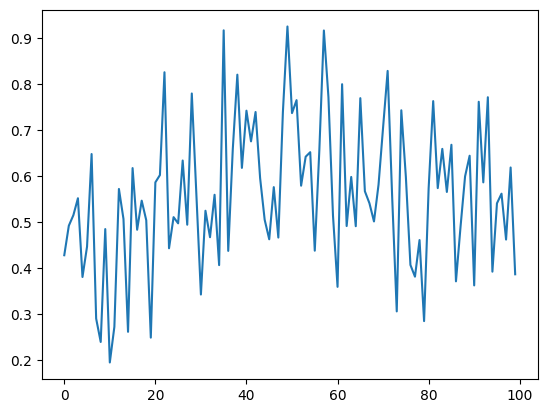

In [27]:
plt.plot(history['ESS'])
plt.savefig('ess.pdf')

and the learning curve for the average work:

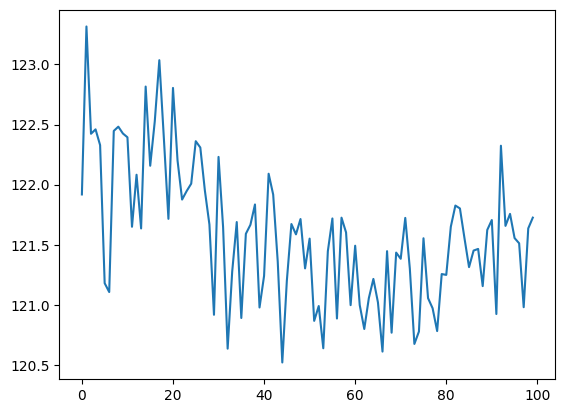

In [16]:
plt.plot(history['loss'])
plt.savefig('loss.pdf')

## Testing

In the following we compute $\Delta F$, ESS, $D_{\text{KL}}$ and $Var(W)$. We will not compute the errors here; in our implementation, the errors are computed using an automatic differentiation method implemented by [pyerros](https://fjosw.github.io/pyerrors/pyerrors.html).

In [17]:
#Function for metrics
from scipy.special import logsumexp
def compute_metrics(w):
    N = w.shape[-1]
    logZ = logsumexp(-w,-1)
    log_ess = 2.0 * logZ - logsumexp(-2 * w,-1)
    ess_per_cfg = np.exp(log_ess) / N
    logZ = logZ - np.log(N)
    return w.mean(), w.var(), -logZ, ess_per_cfg,

In [18]:
n_meas=100 #total number of configurations considered = n_meas * bs

In [19]:
#thermalization and loop over batch:
W=[]
x0, s0 = prior()
for i in (range(n_meas)):
    x0, s0 = prior(cfgs=x0)
    _, w = flow.sample_(x0,s0)
    W.append(grab(w))
W=np.asarray(W).reshape(-1)

In [20]:
work, var_work, DeltaF, ess= compute_metrics(W)

In [21]:
print(f' work: {work},'
      f' w_var: {var_work},'
      f' ess: {ess},'
      f' Delta free energy: {DeltaF}'
      f' Dkl: {work-DeltaF}')

 work: 121.28314823205098, w_var: 1.1933404490798523, ess: 0.3825412279190507, Delta free energy: 120.7276394867531 Dkl: 0.5555087452978711


## Some suggested future implementation

Now that you have played with our SNF, you can try larger volumes, more steps, or different couplings. Additional implementations can include the training used in our paper, i.e., each deterministic layer is trained independently along each forward pass., or the extrapolation of the parameteters.

**Have fun!**